In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [43]:
# Selected Features
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']

# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.shape

(3619, 30)

# Load models

In [49]:
# Decision Tree
decision_tree = DecisionTreeRegressor(**load_params('decision_tree_params.json'))

# Bagging
bagging = BaggingRegressor(**load_params('bagging_params.json'))


# Random Forest
random_forest = RandomForestRegressor(**load_params('random_forest_params.json'))


# Extremely randomized tree
extra_forest = ExtraTreesRegressor(**load_params('extremely_randomized_forest_params.json'))

# Adaboost
adaboost = AdaBoostRegressor(**load_params('adaboost_params.json'))

# sklearn gradient boosting
sk_gb = GradientBoostingRegressor(**load_params('sk_gradient_boosting_params.json'))

# sklearn hist gradient boosting
# with open('saved_models/sk_hist_gradient_boosting_params.json', 'r') as f:
#     sk_hist_params = json.load(f)
hist_sk_gb = HistGradientBoostingRegressor(**load_params('sk_hist_gradient_boosting_params.json'))

# evaluation sets for early stopping
evaluation = [( X_train_np, y_train_np), ( X_val_np, y_val_np)]

# lgbm
#lgbm = lgb.Booster(model_file='saved_models/lgbm_tuned.txt', params = load_params('lgbm_params.json'))
# lgbm_wrapper = LGBMRegressor()
# lgbm_wrapper.set_params(boosting_type='gbdt')
# lgbm_wrapper.set_booster(lgbm)
lgbm = LGBMRegressor(**load_params('lgbm_params.json'))


# XGBOOST
#xgb = xg.XGBRegressor().load_model("saved_models/xgb_model.json")
xgb = xg.XGBRegressor(**load_params('xgb_params.json'))

# xgb.set_params(early_stopping_rounds=10)

In [56]:
def vote_prediction(estimators,X_train_np,y_train_np,X_test_np, weights = None):
    '''
    compute predictions and make an average
    
    INPUTS:
        estimators : list of tuples containing a (string,model)
        X_train_np : training feature matrix as numpy array
        y_train_np : y labels for training
        X_test_np  : test feature matrix as numpy array
        
    OUTPUTS:
        y_pred : predicted labels
    '''
    y_pred = []
    for est_name, estimator in estimators:
        y_pred.append(np.maximum(0,estimator.fit(X_train_np, y_train_np).predict(X_test_np)))
    
    if weights == None:
        y_pred = np.mean(y_pred, axis = 0)
    else:
        y_pred = np.sum([weights[i]*y_pred[i] for i in range(len(weights))],axis=0)
    return y_pred

import time
start = time.time()
estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
y_pred = vote_prediction(estimators,X_train_np,y_train_np,X_test_np, [1/5]*5)
print(time.time()-start)

99.50372266769409


109.209312915802


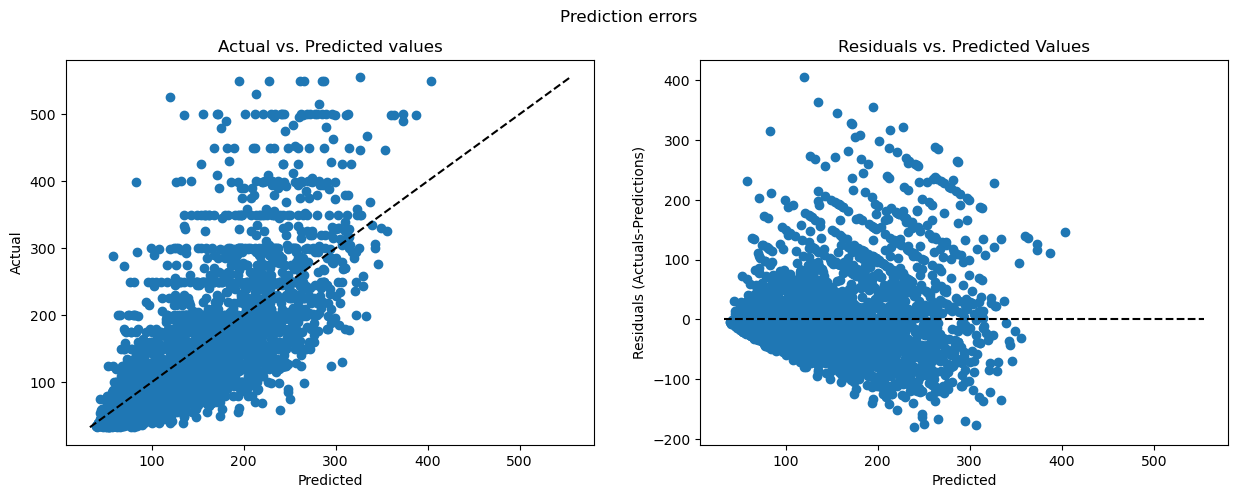

R²: 0.5719832455335383
MAE: 40.564262763202514
MSE: 3829.1501685874405
RMSE: 61.88012741250167
MAPE: 0.31569392544676317
error_ratio_rmse: 0.44740337695107213
error_ratio_mae: 0.29328621162665647


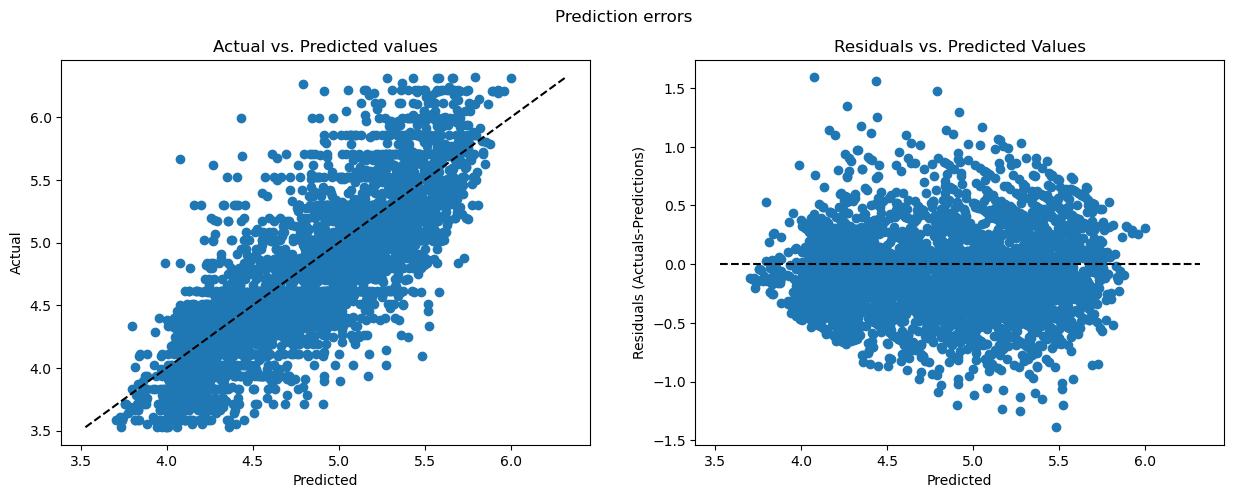

R²: 0.6612122158895757
MAE: 0.28333594741932777
MSE: 0.13166322445494805
RMSE: 0.3628542744063353
MAPE: 0.060978641038708134
error_ratio_rmse: 0.07658179333120486
error_ratio_mae: 0.05979914389617907


In [58]:
start = time.time()

vote = VotingRegressor(estimators=[ ('xgb',xgb),
                                    ('lgbm', lgbm),
                                    ('hist_sk_gb', hist_sk_gb),
                                    ('extra_forest', extra_forest),
                                    ('random_forest', random_forest)]).fit(X_train_np, y_train_np)

y_pred = np.maximum(0,vote.predict(X_test_np))
print(time.time()-start)

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

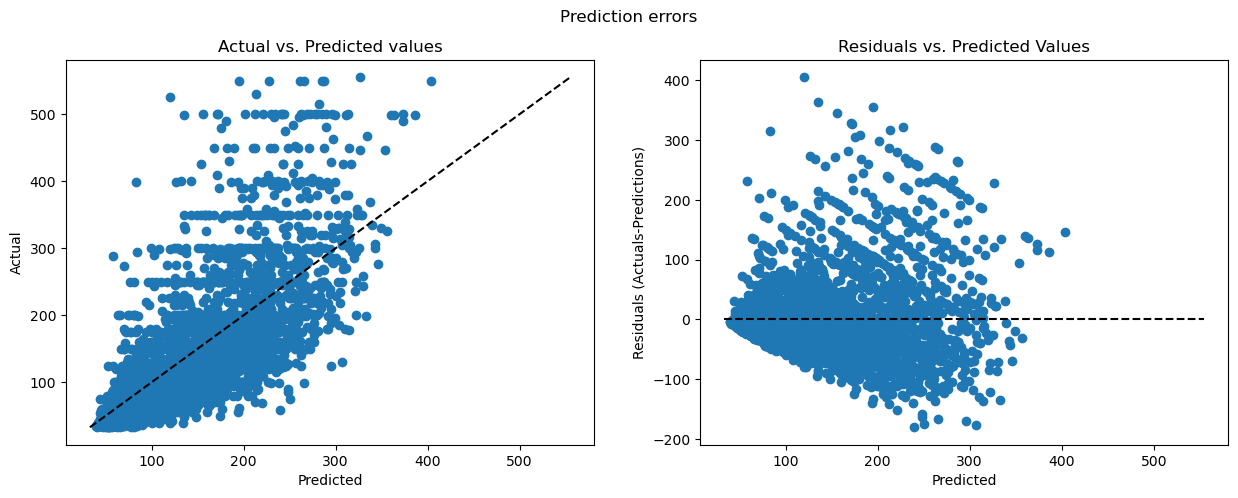

R²: 0.5719611671816873
MAE: 40.56580329746757
MSE: 3829.3476873149903
RMSE: 61.881723370596184
MAPE: 0.31568766971268386
error_ratio_rmse: 0.44741491598744476
error_ratio_mae: 0.29329734993973555


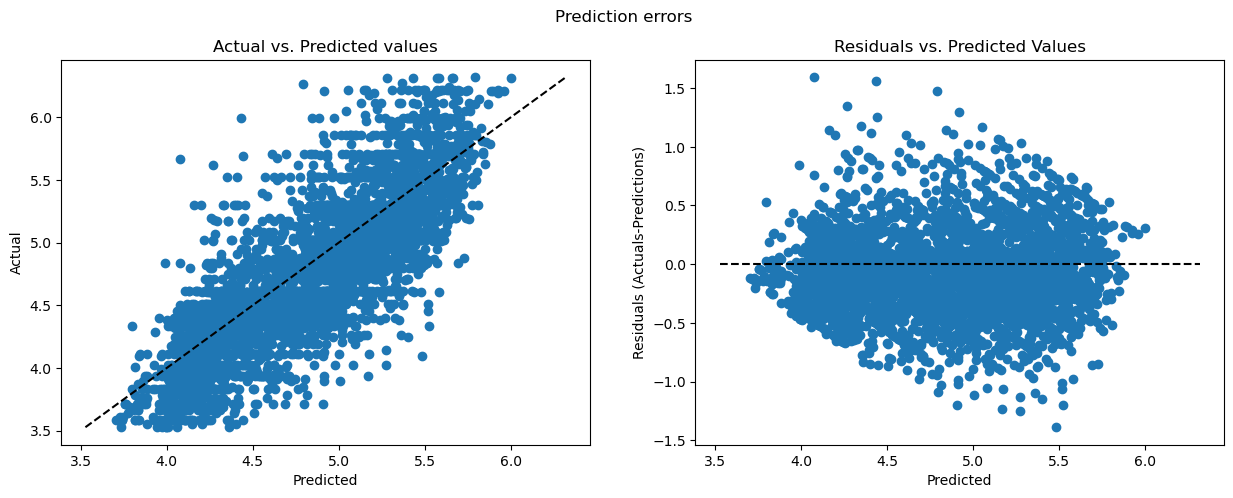

R²: 0.6612193980332817
MAE: 0.28333488238269433
MSE: 0.13166043325572785
RMSE: 0.36285042821488833
MAPE: 0.060977557473026495
error_ratio_rmse: 0.07658098157767383
error_ratio_mae: 0.059798919116092114


In [57]:
# y_pred = np.maximum(0,vote.predict(X_test_np))

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [61]:
space = {
    'w1': hp.uniform('w1', 0, 1),
    'w2': hp.uniform('w2', 0, 1),
    'w3': hp.uniform('w3', 0, 1),
    'w4': hp.uniform('w4', 0, 1),
    'w5': hp.uniform('w5', 0, 1)
}


def objective(weights):
    # Normalize the weights to sum to 1
    weights_normalized = [w/sum(weights.values()) for w in weights.values()]
    
    estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
    y_pred = vote_prediction(estimators,X_train_np,y_train_np,X_test_np, weights_normalized)
    
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

R²: 0.5730492303257                                                                                                    
MAE: 40.49766401365214                                                                                                 
MSE: 3819.613588993247                                                                                                 
RMSE: 61.80302249075887                                                                                                
MAPE: 0.3154776924732841                                                                                               
error_ratio_rmse: 0.44684589583702533                                                                                  
error_ratio_mae: 0.29280469184485436                                                                                   
SCORE:                                                                                                                 
61.80302249075887                       

error_ratio_rmse: 0.44802395967018604                                                                                  
error_ratio_mae: 0.29376184260821336                                                                                   
SCORE:                                                                                                                 
61.965959884286896                                                                                                     
R²: 0.5713031710141223                                                                                                 
MAE: 40.61911392100558                                                                                                 
MSE: 3835.23429364446                                                                                                  
RMSE: 61.9292684733516                                                                                                 
MAPE: 0.31381171895863763               

MAE: 40.82603610102434                                                                                                 
MSE: 3872.8041557472243                                                                                                
RMSE: 62.23185804511403                                                                                                
MAPE: 0.3168949849378479                                                                                               
error_ratio_rmse: 0.44994644658244                                                                                     
error_ratio_mae: 0.29517887539828247                                                                                   
SCORE:                                                                                                                 
62.23185804511403                                                                                                      
R²: 0.572792318640061                   

In [62]:
best_hyperparams

{'w1': 0.3776112541796772,
 'w2': 0.642113280042596,
 'w3': 0.05625227294665702,
 'w4': 0.23555889944111896,
 'w5': 0.22324221020388602}

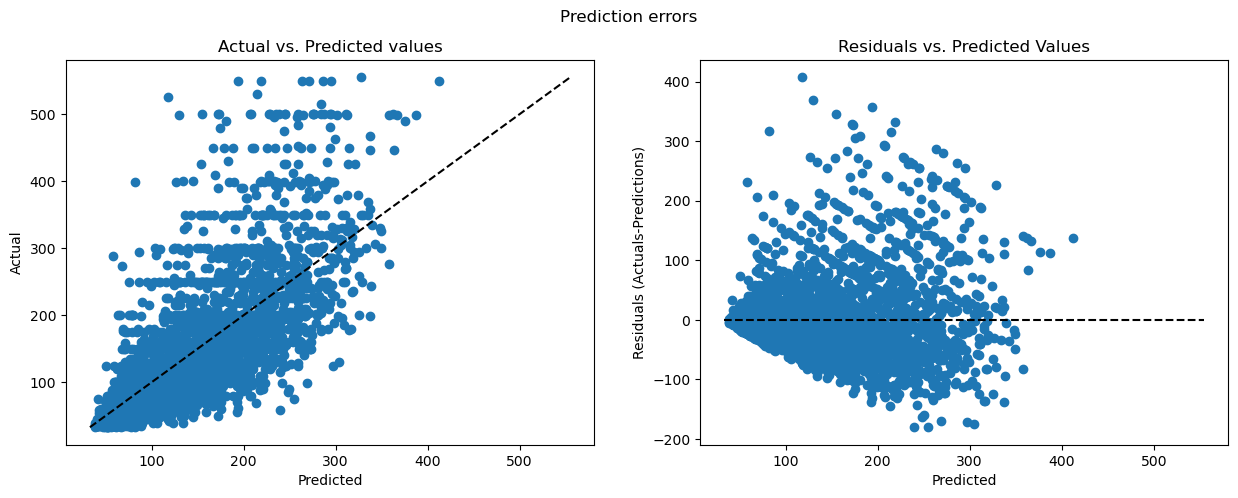

R²: 0.5732804901756522
MAE: 40.504543745418076
MSE: 3817.544677708371
RMSE: 61.78628227777077
MAPE: 0.31433762405575244
error_ratio_rmse: 0.4467248613767724
error_ratio_mae: 0.2928544334235049


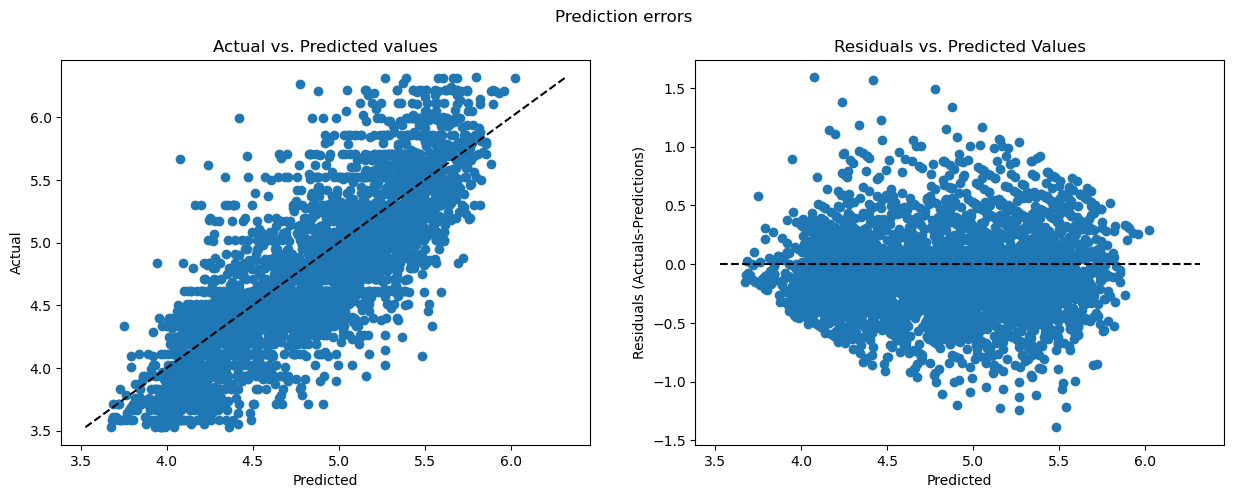

R²: 0.6627455864820151
MAE: 0.2826405377457446
MSE: 0.13106731006265354
RMSE: 0.3620321947874989
MAPE: 0.06077707765640504
error_ratio_rmse: 0.07640829025872617
error_ratio_mae: 0.05965237500392887


In [63]:
# Normalize the weights to sum to 1
weights_normalized = [w/sum(best_hyperparams.values()) for w in best_hyperparams.values()]

estimators = [ ('xgb',xgb),('lgbm', lgbm),('hist_sk_gb', hist_sk_gb),('extra_forest', extra_forest),('random_forest', random_forest)]
y_pred = vote_prediction(estimators,X_train_np,y_train_np,X_test_np, weights_normalized)
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

In [64]:
vote_params = best_hyperparams

# Save the parameters as a JSON file
with open('saved_models/vote_params.json', 'w') as f:
    json.dump(vote_params, f)